## Multiple Comparison Corrections

In [1]:
%load_ext autoreload
%autoreload 2
import ccs_eeg_utils
from matplotlib import pyplot as plt
import numpy as np
import mne.stats
import scipy.stats


Use `data = ccs_eeg_utils.ex8_simulateData()` to simulate a simple difference between two condition. Instead of electrodes x time, we now have a simple rectangular matrix (or $n_{subject}=15$ of them), but the principles of multiple comparison corrections, can be applied to it as well.

**T:** calculate the mean of the data over subjects and plot it as an image

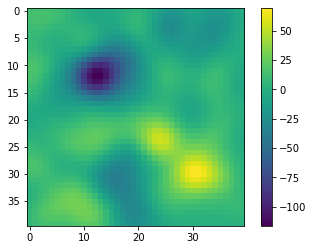

In [2]:
data = ccs_eeg_utils.ex8_simulateData()
plt.imshow(data.mean(axis=0))
plt.colorbar()

**T:** Plot some subjects individually. Can you infer anything from the "single subject" displays?

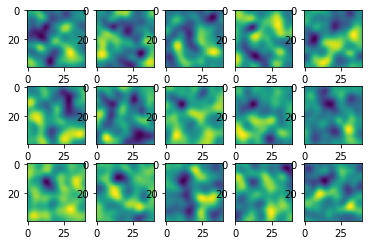

In [3]:
ax = plt.subplots(3,5)
for k in range(15):
    plt.subplot(3,5,k+1).imshow(data[k,:,:])



In [4]:
def plot_stats(stats):
    # a list of statistics
    n = len(stats)
    fig,ax = plt.subplots(n,3)
    for k in range(len(stats)):
        ax1 = plt.subplot(n,3,k*3+1)
        ax2 = plt.subplot(n,3,k*3+2)
        ax3 = plt.subplot(n,3,k*3+3)

        im = ax1.imshow(stats[k][0],cmap="RdBu",clim=[-5,5])
        ax1.set_yticklabels([]);ax1.set_xticklabels([]);ax2.set_yticklabels([]);ax2.set_xticklabels([]);ax3.set_yticklabels([]);ax3.set_xticklabels([])
        plt.colorbar(im,ax=ax1)
        im = ax2.imshow(np.log10(stats[k][1]),cmap="BuPu",clim=[-3,0]);
        
        cbar = plt.colorbar(im,ax=ax2,ticks=np.log10([1,0.05,0.01,0.001]))
        cbar.ax.set_yticklabels([None,0.05,0.01,0.001])
        m = np.ma.masked_where(stats[k][1]>0.05,stats[k][0])
        im = ax3.imshow(m,cmap="RdBu",clim=[-5,5])

### T-Values
The t-value is a weighting of your effect-strength (i.e. the difference between the means of two conditions) and the standard deviation (=spread) of this effect. $t = \frac{mean(x)}{\frac{std(x)}{\sqrt(n-1)}}$. Use this formula to manually compare the t-values over the n=15 subjects. Compare it with `scipy.stats.ttest_1samp(data,popmean=0,axis=0)`.

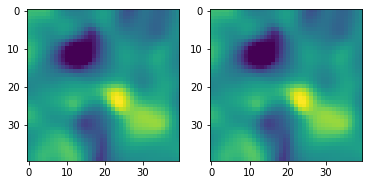

In [5]:
tstat_man = data.mean(axis=0)/(data.std(axis=0)/np.sqrt(14))
tstat =scipy.stats.ttest_1samp(data, popmean= 0, axis=0)
plt.subplot(1,2,1).imshow(tstat_man,clim=[-5,5])
plt.subplot(1,2,2).imshow(tstat.statistic,clim=[-5,5])


**T:** The scipy function also returns p-values. We want to plot the t-values next to the p-values. Because we will iteratively add different multiple comparison corrections, it is best to generate a function that allows to subsequently increase the amount of plots one can plot. I recommend to plot the log10(p-values)

**Bonus:** You can also use `m = np.ma.masked_where(pvalues>0.05,tvalues)` to get a nice masked view of the data.

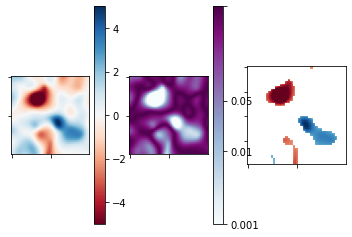

In [6]:
plot_stats([tstat])

## False Discovery Rate
We will investigate False Discovery Rate a bit. First let's generate data without any effect and only with noise. Thus all possible findings with p<0.05 have to be false positives

**T:** run `data_h0 = ccs_eeg_utils.ex8_simulateData(signal_mean=0,noise_between=0) ` and plot the t-values as an imshow (be sure to add a colorbar always)

**T:** plot a histogram of all p-values (regardless of position)

**T:** Also plot a histogram of the p-values of the data with the effect


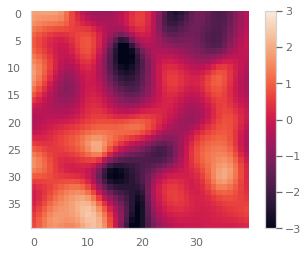

In [201]:
data_h0 = ccs_eeg_utils.ex8_simulateData(signal_mean=0,noise_between=0)
ttest_h0 = scipy.stats.ttest_1samp(data_h0,popmean=0,axis=0)
plt.imshow(ttest_h0.statistic,clim=[-3,3])
plt.colorbar()


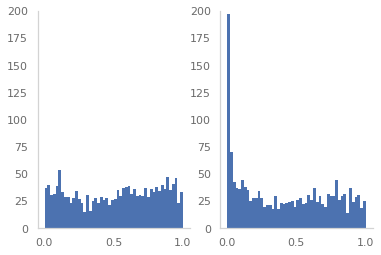

In [205]:
plt.subplot(1,2,1).hist(ttest_h0.pvalue.reshape(np.prod(data_h0.shape[1:])),50),plt.ylim([0,200]);
plt.subplot(1,2,2).hist(tstat.pvalue.reshape(np.prod(data_h0.shape[1:])),50),plt.ylim([0,200]);


**T:** Count how many pvalues are below 0.05 each from the data with and without effect. For FDR we have to estimate how many "significant" (=> pvalue<$\alpha$, with $alpha=0.05$ typically) values we would get by chance (=false positives). Instead of estimating the number of p-values from one dataset (which is much more involved), we can also take our null-model pvalue-count as well. Calculate the ratio of H0/H1 significant-pvalues. This is your False-Discovery rate. Can you manually adjust alpha, so that the FDR is 0.05?


In [127]:
alpha = 0.05
nofdr  = np.sum(tstat.pvalue<alpha)
nofdr_h0 = np.sum(ttest_h0.pvalue<alpha)
yesfdr = np.sum(mne.stats.fdr_correction(tstat.pvalue)[1]<0.05)
print("before fdr {}, h0 {:.3f}, ratio for alpha {}: {:.2f} FalsePositives, after fdr-mne: {}, fdr-manual: {}".format(nofdr,nofdr_h0,alpha,nofdr_h0/nofdr,yesfdr,np.sum(tstat.pvalue<0.007)))

before fdr 287, h0 88.000, ratio for alpha 0.05: 0.31 FalsePositives, after fdr-mne: 88, fdr-manual: 131


**T:** Use `mne.stats.fdr_correction` to calculate the proper fdr-correction. Use the plotting function from the beginning to directly compare the p-values with and without correction.

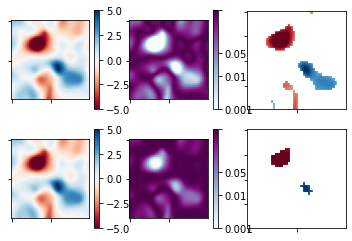

In [465]:
fdr= (tstat.statistic,mne.stats.fdr_correction(tstat.pvalue)[1])
plot_stats([tstat,fdr])

## Bonus: F-Max Permutation test
In the lecture we discussed permutation tests and permutation cluster tests. What we didnt discuss is that you can easily adjust a permutation test to correct for multiple comparisons. We permute each 40x40 grid element concurrently, but instead of saving for each grid element the permuted statistics (e.g. the t-value), we save the maximum of all grid elements. This biases our permutation distribution towards large t-values, and concurrently makes it harder for the observed value to "stand out" (=> be unlikely) from that distribution.
You can use `mne.stats.permutation_t_test` to calculate this.


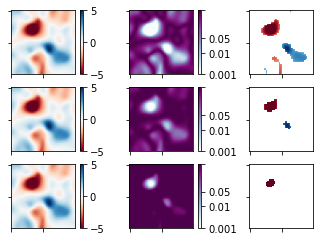

In [466]:
data_flat = data.copy()
data_flat.shape = (data.shape[0], data.shape[1]*data.shape[2])
perm= mne.stats.permutation_t_test(data_flat, verbose=False)
perm[0].shape = data.shape[1:]
perm[1].shape = data.shape[1:]

plot_stats([tstat,fdr,perm])

## Cluster Permutation Tests
We will implement a simple cluster permutation test, before making use of the mne-implementation. For this we need the package `scikit-image` to be able to use `skimage.measure.label` to get the clusters.

A cluster permutation test has the following structure

1. calculate `t_obs`, the t-values for your observed data (as before `mne.stats.ttest_1samp_no_p`)
2. Threshold `t_obs` using `scipy.stats.t.ppf(1-(2*alpha), n-1)` as the threshold value. This converts a p-value back to the t-value. In principle you could also decide to use a t-theshold of e.g. 2. The threshold is arbitrarily set, but important.
3. Because our cluster are in image-space, neighbours can easily be calculated using `skimage.measure.label`
4. Find the largest cluster and save it to `c_obs`
5. Permutation, do 1000 times:
    1. generate a `signFlip` vector with length `n` (by default n=15 subjects) consisting of random "1" and "-1", one for each subject. Assuming the $H_0$ is true (which we do in this loop), the sign around "0" is random for each subject, so no harm should be done in flipping it (it will change the resulting statistic obviously, but doing it 1000 time shoudnt introuce / hide an effect)
    2. Multiply the `signFlip` vector to the data
    3. repeat step 1-4 of the observed data for the permuted data to get `c_perm`
    4. Save this largest clustersize
6. Append `c_obs` to your `c_perm` (the simplified reason is, that else you could get a p-value of 0 [more details if of interest](https://benediktehinger.de/blog/science/permutation-test-for-matlab/))
7. `1 - np.mean(c_obs>=c_perms)` gives you your p-value

Note: The test could be improved by e.g. summing the t-values of a cluster instead of merely counting the cluster-extend, but that leads us a bit astray from what we want to understand here.


In [200]:
from skimage.measure import label

def calc_max_cluster(t_star,alpha=0.05,n = 15):
    thr = scipy.stats.t.ppf(1-(2*alpha), n-1)
    i,c = np.unique(label(np.abs(t_star)>thr),return_counts=True)
    # remove the first because it is "0" => no effect
    return np.max(c[1:])
# calculate statistic
t_obs = mne.stats.ttest_1samp_no_p(data)
# calculate max clustersize
c_obs = calc_max_cluster(t_obs)
# permute 100 times
n_perm = 1000
c_perms = np.zeros(shape=n_perm)
c_perms[len(c_perms)-1] = c_obs
for p in range(n_perm-1):
    signFlip = (np.random.rand(15)>0.5)*2-1
    # python doesnt support broadcasting of vectors to 3d matrice. I.e. this should do
    # signFlip * data, i.e. multiply/flip each subject by a random +1 / -1
    d_perm = np.einsum('t,tnh-> tnh',signFlip,data)
    t_perm = mne.stats.ttest_1samp_no_p(d_perm)
    c_perms[p] = calc_max_cluster(t_perm)
    

p_val = 1-np.mean(c_obs>=c_perms)
p_val

0.08199999999999996

**T:** Running a simular permutation test in MNE is much easier:
```python
t_clust, clusters, p_values, H0 = mne.stats.permutation_cluster_1samp_test(
    data, threshold=threshold, adjacency=None,
    n_permutations=1000, out_type='mask')
```
- The threshold is the same threshold you used before
- Typically we would have to supply the adjacency manually, because the adjancy depends on which channels are next to eachother. But in this case we can put `None` and mne will assume it is a grid-structure

In order to fill the clusters with their respective p-values:

```python
p_clust = np.ones(data.shape[1:])
for cl, p in zip(clusters, p_values):
    p_clust[cl] = p
```
This step is controversial, because clusters do not have any real p-value [see here, "interpretation of significant TFCE value"](https://benediktehinger.de/blog/science/threshold-free-cluster-enhancement-explained/). But pragmatically, I think it is still useful to gauge the Signal-To-Noise ratio of the clusters. As long as you do not literally interpret the p-value as a probability, you should be fine.

**T:** Add the cluster-permutation to your comparison plot

stat_fun(H1): min=-8.247474 max=5.110684
Running initial clustering
Found 11 clusters
Permuting 999 times...
100%|██████████|  : 999/999 [00:00<00:00, 2084.59it/s]Computing cluster p-values
Done.



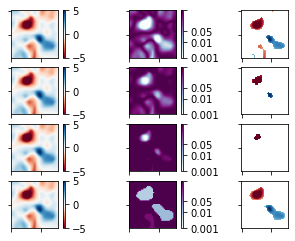

In [467]:
threshold = scipy.stats.distributions.t.ppf(1 - 0.05, 15 - 1)
t_clust, clusters, p_values, H0 = mne.stats.permutation_cluster_1samp_test(
    data, threshold=threshold, adjacency=None,
    n_permutations=1000, out_type='mask')


p_clust = np.ones(data.shape[1:])
for cl, p in zip(clusters, p_values):
    p_clust[cl] = p

cluster = (t_clust,p_clust)
plot_stats([tstat,fdr,perm,cluster])

## TFCE
last but not least, we will get rid of this initial cluster-formung threshold. TFCE integrates over all possible thresholds. We will not implement TFCE here, but simply call the mne-python function.
```python
t_tfce, _, p_tfce, H0 = mne.stats.permutation_cluster_1samp_test(
    data, adjacency=None,threshold = dict(start=0, step=0.2),
    n_permutations=1000, out_type='mask')
```

**T:** Add this to your comparison plot. We are done! I hope you learned the differences and underlying algorithms of several multiple-comparison corrects!

stat_fun(H1): min=-8.247474 max=5.110684
Running initial clustering
Using 42 thresholds from 0.00 to 8.20 for TFCE computation (h_power=2.00, e_power=0.50)
Found 1600 clusters
Permuting 999 times...
100%|██████████|  : 999/999 [00:09<00:00,  106.96it/s]
Computing cluster p-values
Done.


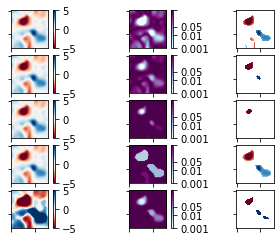

In [468]:
t_tfce, _, p_tfce, H0 = mne.stats.permutation_cluster_1samp_test(
    data, adjacency=None,threshold = dict(start=0, step=0.2),
    n_permutations=1000, out_type='mask')
p_tfce.shape = t_tfce.shape
tfce = (t_tfce,p_tfce)
plot_stats([tstat,fdr,perm,cluster,tfce])